<a href="https://colab.research.google.com/github/eshaanraj/nfl_draft_model/blob/main/nfl_draftability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Head:
    Year                   Player   Age       School  Height      Weight  \
0  2009    Beanie Wells\WellCh00  20.0     Ohio St.  1.8542  106.594207   
1  2009      Will Davis\DaviWi99  22.0     Illinois  1.8796  118.387609   
2  2009  Herman Johnson\JohnHe23  24.0          LSU  2.0066  165.107623   
3  2009  Rashad Johnson\JohnRa98  23.0      Alabama  1.8034   92.079251   
4  2009      Cody Brown\BrowCo96  22.0  Connecticut  1.8796  110.676538   

   Sprint_40yd  Vertical_Jump  Bench_Press_Reps  Broad_Jump  Agility_3cone  \
0         4.38          85.09              25.0      325.12            NaN   
1         4.84          83.82              27.0      292.10           7.38   
2         5.50            NaN              21.0         NaN            NaN   
3         4.49          93.98              15.0      304.80           7.09   
4         4.76          92.71              26.0      304.80           7.10   

   Shuttle                          Drafted..tm.rnd.yr.        BMI  \
0  

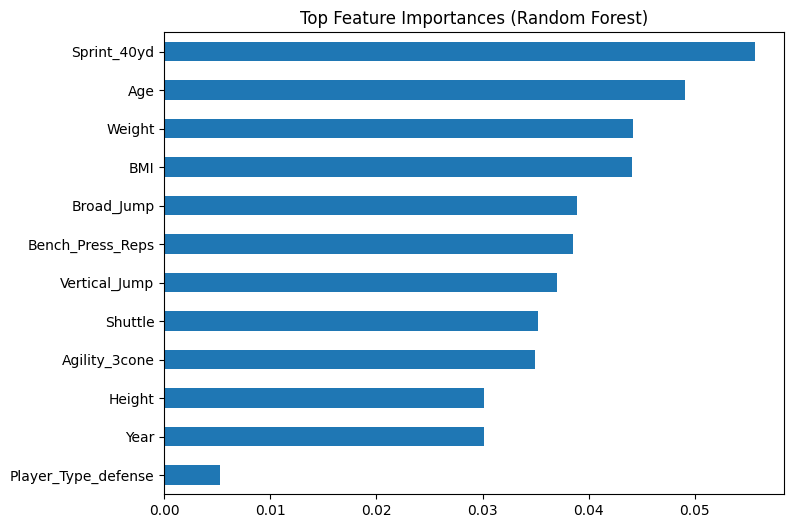

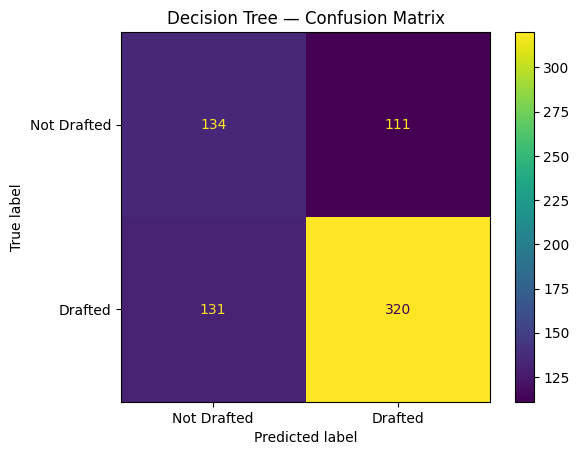

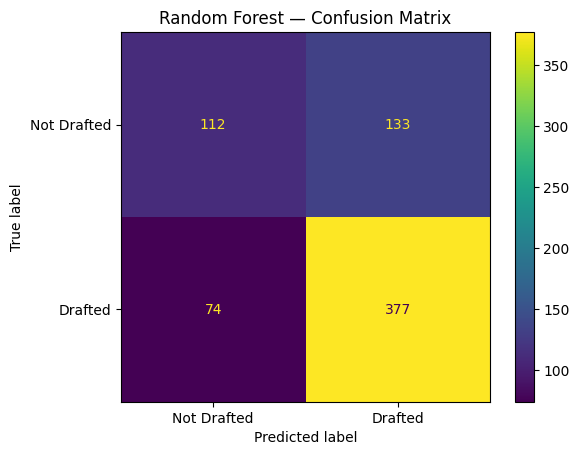

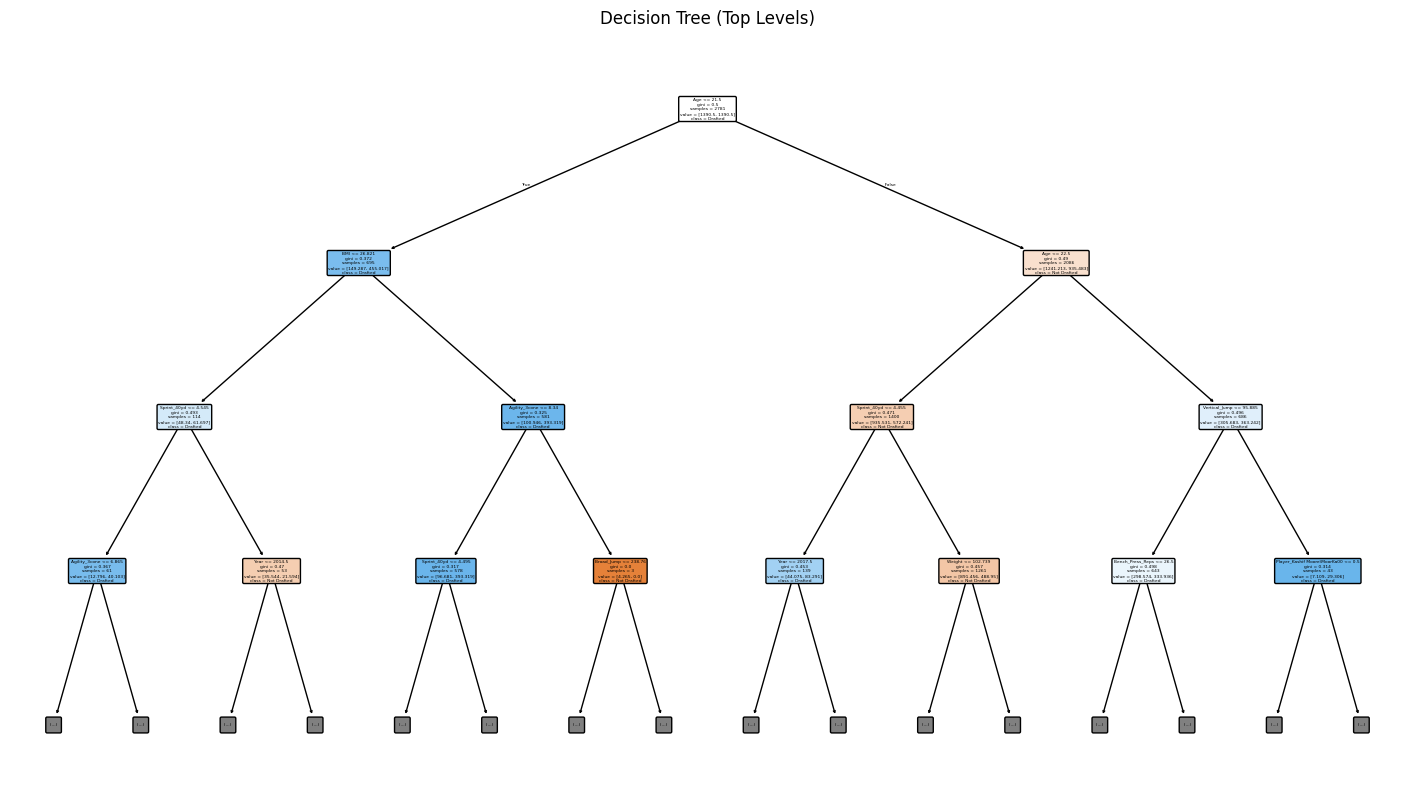

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# ===== 1) Load data =====
CSV_PATH = "/content/NFL.csv"  # set by the upload step
df = pd.read_csv(CSV_PATH)
print("Head:\n", df.head())

# ===== 2) Features/target =====
y = df["Drafted"]  # 1 = drafted, 0 = not drafted
X = pd.get_dummies(df.drop(columns=["Drafted"]), drop_first=False)
X = X.fillna(X.median(numeric_only=True))

# ===== 3) Train/test split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===== 4) Decision Tree (with CV) =====
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")
cv_scores = cross_val_score(dt, X_train, y_train, cv=cv, n_jobs=-1)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

print(f"\nDecision Tree CV mean: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"Decision Tree Accuracy: {accuracy_score(y_test, dt_pred):.3f}")
print("Decision Tree Report:\n", classification_report(y_test, dt_pred))

# ===== 5) Random Forest =====
rf = RandomForestClassifier(
    n_estimators=300, n_jobs=-1, random_state=42, class_weight="balanced"
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print(f"\nRandom Forest Accuracy: {accuracy_score(y_test, rf_pred):.3f}")
print("Random Forest Report:\n", classification_report(y_test, rf_pred))

# ===== 6) Plots =====
# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(12)
plt.figure(figsize=(8,6))
importances.iloc[::-1].plot(kind="barh")
plt.title("Top Feature Importances (Random Forest)")
plt.show()

# Confusion matrices
for name, pred in [("Decision Tree", dt_pred), ("Random Forest", rf_pred)]:
    ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=["Not Drafted", "Drafted"])
    plt.title(f"{name} — Confusion Matrix")
    plt.show()

# Show top levels of the tree (readable)
plt.figure(figsize=(18,10))
plot_tree(dt, feature_names=X.columns, class_names=["Not Drafted", "Drafted"], filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree (Top Levels)")
plt.show()
